# __Uniformly hypocoercive numerical scheme for linear kinetic equation__

In the following we discretize either the Fokker-Planck equation

$$\varepsilon\,\partial_t f^\varepsilon + v\cdot\nabla_x f^\varepsilon = \frac{1}{\varepsilon}\nabla_v\cdot\left(\mathcal{M}(v)\nabla_v\frac{f^\varepsilon}{\mathcal{M}(v)}\right)$$

either the relaxation (or linear BGK) equation

$$\varepsilon\,\partial_t f^\varepsilon + v\cdot\nabla_x f^\varepsilon = \frac{1}{\varepsilon}\left(\rho^\epsilon\mathcal{M}(v) - f^\varepsilon\right)\,,\qquad \rho^\varepsilon(t,x)\ =\ \int f^\varepsilon(t,x,v)\,\mathrm{d}v$$

In [78]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 10.0         # bigger font size
plt.rcParams['mathtext.fontset'] = 'cm'  # computer moder math font
plt.rcParams['text.usetex'] = True       # use tex engine for everything (useful for the axes labels)

PLOTEVERYTHING = False

In [50]:
equation = 2
if equation == 1:
    name = "kinetic_FP"
elif equation == 2:
    name = "BGK"
elif equation == 3:
    name = "Heavy-tailed BGK" # Marche pas !
    
epsilon = 1

## Discretization parameters

### Velocity discretization

The velocity domain is a bounded symmetric segment $[-v_{\star},v_{\star}]$. 
We consider a primal mesh of this interval composed of $N_v = 2L$ control volumes arranged symmetrically around $v = 0$. We thus get $2L+1$ distinct interface points denoted by $v_{j+\frac{1}{2}}$. In this way $v_{-L+1/2} = -v_{\star}$, $v_{1/2} = 0$ and $v_{j+1/2} = -v_{-j+1/2}$. Each cell has length $\Delta v_{j}=v_{j+\frac{1}{2}}-v_{j-\frac{1}{2}}$ and midpoint $v_j$.

In [51]:
vstar = 8
L = 20

In [52]:
vmax = vstar
vmin = -vstar
Nv = 2 * L

# Number of cells (must be even)

vhalf = np.linspace(vmin,vmax, Nv+1) # Interface points
dv = np.diff(vhalf) 
v = vhalf[:len(vhalf)-1] + dv*.5  # Cell centers

In [53]:
if PLOTEVERYTHING:
    plt.figure
    plt.ylabel('$v$')
    plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
    plt.grid(True)
    plt.ylim([vmin,vmax])
    plt.plot(0*vhalf,vhalf, label = 'Interfaces', marker = 'o', ls = 'None')
    plt.plot(0*v,v, label = 'Cell centers', marker = 'x', ls = 'None')
    plt.title("Velocity discretization")
    plt.legend()
    plt.show()

### Space discretization

In space, we consider a discretization of the torus $\mathbb{T}$ into $N_x$ subintervals of length $\Delta x_{i}$ and centers $x_{i}$.

In [54]:
Nx = 51 #must be odd

In [55]:
taille = 0.25*np.pi

xmin = 0
xmax = taille

xhalf = np.linspace(xmin,xmax, Nx + 1)
dx = np.diff(xhalf)
xhalf = xhalf[:len(xhalf)-1] # Interface points
x = xhalf + dx*0.5  # Cell centers

In [56]:
if PLOTEVERYTHING:
    plt.figure
    plt.xlabel('$x$')
    plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
    plt.grid(True)
    plt.xlim([xmin,xmax])
    plt.plot(xhalf,0*xhalf, label = 'Interfaces', marker = 'o', ls = 'None')
    plt.plot(x,0*x, label = 'Cell centers', marker = 'x', ls = 'None')
    plt.title("Space discretization")
    plt.legend()
    plt.show()

### Creation of the grid

In [57]:
[X,V] = np.meshgrid(x,v)
DV = np.transpose(np.tile(dv,(Nx,1)))
DX = np.tile(dx,(Nv,1))
N = Nx * Nv

### Time discretization

The time step $\Delta t$ is uniform until final time $T$

In [58]:
dt = 0.1
T  = 35

## Discrete Maxwellian

We are given interface  values $(\mathcal{M}_{j+1/2}^*)_{j}$ and cell values $(\mathcal{M}_{j})_{j}$ 
such that
$$
\left\{
\begin{array}{l}
\mathcal{M}_{j+1/2}^*\ =\ \mathcal{M}_{-j+1/2}^*\\[.75em]
\mathcal{M}_{L+1/2}^*\ =\ \mathcal{M}_{-L+1/2}^*\ =\ 0\\[.75em]
\displaystyle\mathcal{M}_j\ :=\ \frac{\mathcal{M}_{j-1/2}^* - \mathcal{M}_{j+1/2}^*}{v_j\,\Delta v_j}\,>\,0\\[.75em]
\displaystyle\sum_{j}\mathcal{M}_j\,\Delta v_j\ =\ 1\,.\quad\\[.75em]
\end{array}
\right.
$$

In [59]:
def gaussian(u):
    return np.exp(-u * u / 2) / np.sqrt(2 * np.pi)

def polynomial(u):
    return np.exp(-abs(u)) #1./(1+u**8)
    
if equation == 3: 
    Mhalf = polynomial(vhalf)
else:    
    Mhalf = gaussian(vhalf) # At interfaces 

Mhalf[len(Mhalf)-1] = 0 
Mhalf[0] = 0

M = - np.diff(Mhalf) / v / dv # In cells

MassM = np.sum(M * dv) # Normalize mass
M = M / MassM
Mhalf = Mhalf / MassM

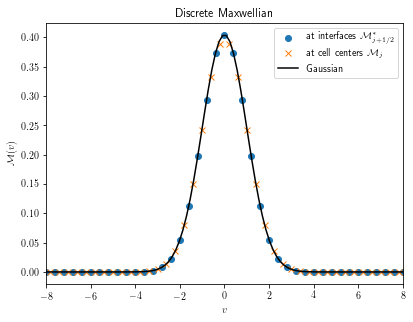

In [60]:
plt.figure
plt.xlabel('$v$')
plt.ylabel('$\mathcal{M}(v)$')
plt.xlim([vmin,vmax])
plt.plot(vhalf, Mhalf, label = 'at interfaces $\mathcal{M}_{j+1/2}^*$', marker = 'o', ls = 'None')
plt.plot(v,M, label = 'at cell centers $\mathcal{M}_{j}$', marker = 'x', ls = 'None')
vplot = np.linspace(vmin,vmax,100)
if equation == 3:
    Mplot = polynomial(vplot)
else:
    Mplot = gaussian(vplot)

Mplot = Mplot/MassM
plt.plot(vplot, Mplot, label = "Gaussian", color = 'black')
plt.title("Discrete Maxwellian")
plt.legend()
plt.show()

## Initial data and steady state

### Initial data 
The initial data is given by
$$
f^0_{ij}\ =\ g(x_i,v_j)
$$
with 
$$
g(x,v)\ =\ \frac{1}{\sqrt{2\pi}}\,v^4\,e^{-v^2/2}\,\frac{1+\cos(4\pi x)}{2} 
$$

In [61]:
testcase = 4

def init_Oscillation(X,V): ### Small perturbation of the gaussian ~first Fourier mode ###
    return gaussian(V) * (1 + 1*np.cos(2 * np.pi * X / taille))

def init_FullRandom(X,V):  
    return np.random.random_sample(np.shape(V))

def init_TruncatedRandom(X,V):
    return np.random.random_sample(np.shape(V))*(abs(V)< 3)

def init_ball(X,V):
    return np.hypot(X-0.5,V/16) < 0.2

def init_complicated(X,V):
    return gaussian(V)*V**4*(1+1*np.cos(2 * np.pi * X / taille))

if testcase == 1:
    F = init_FullRandom(X,V)
elif testcase == 2:
    F = init_TruncatedRandom(X,V)
elif testcase == 3:
    F = init_ball(X,V)
elif testcase == 4:
    F = init_Oscillation(X,V)
elif testcase == 5:
    F = init_complicated(X,V)
    
f   = np.reshape(F,N) # Initial data for kinetic equation
F0  = F.copy()

rho = np.transpose(np.sum(F * DV,0))
Rho = np.tile(rho,(Nv,1))
rho_heat = rho # Initial data for heat equation

In [62]:
sameinitcondrand = False
if sameinitcondrand:
    F = F0.copy()
    rho = np.transpose(np.sum(F * DV,0))
    Rho = np.tile(rho,(Nv,1))
    rho_heat = rho # Initial data for heat equation

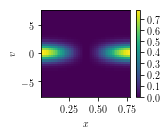

In [63]:
plt.rcParams['figure.figsize'] = 2., 1.6  # size of the inline plot, in inches
plt.pcolor(X,V,F, cmap=plt.cm.viridis)
plt.colorbar()
plt.xlabel(r'$x$')
plt.ylabel(r'$v$')
#plt.axes().set_aspect('equal', 'datalim')
plt.savefig("InitDat" + str(testcase) + ".pdf", bbox_inches="tight")
plt.show()

### Steady state 
The steady state is a Maxwellian with the same mass as the initial data
$$
f^\infty_{ij}\ =\ m_f\,\mathcal{M}_j
$$
with 
$$
m_f = \sum_{i,j}f^0_{ij}\,\Delta x_i\,\Delta v_j
$$

In [64]:
mf = np.sum(rho * dx) / taille
MM = np.transpose(np.tile(M,(Nx,1)))
Finf = MM * mf
finf = np.reshape(Finf,(N,1)) # Steady state
rhoinf = np.transpose(np.sum(Finf * DV,0))

### Micro-macro unknowns

The micro unknown $(h_{ij}^n)$ and macro unknown $(\lambda_{i}^n)$ are such that
$$
 f_{ij}^n\ =\ m_f\,\mathcal{M}_j  + \lambda_i^n\,\mathcal{M}_j + \varepsilon\,h_{ij}^n\,\mathcal{M}_j
$$
$$
 \lambda_{i}^n\ =\ \rho_i^n - m_f = \sum_{j} f_{ij}^n\,\Delta v_j-m_f
$$

In [65]:
if (epsilon>0):
    H = (F - Rho*MM) / epsilon 
else:
    H = 0 * F

h = np.reshape(H,N)# Perturbative micro unknown

lamb = np.reshape(rho - mf,Nx) # Perturbative macro unknown
lamb_heat = lamb
Lamb = Rho - mf 

unknown = np.concatenate((lamb,h))

## Building matrices  

### Periodic indices

In [66]:
def indx(i):
    return i % Nx
def ind(i,j):
    return indx(i) + j * Nx

### Matrix for heat equation

In [67]:
m2dv = np.sum(M * v * v * dv); # Diffusion coefficient

Mat_heat = np.eye(Nx)

for i in range(0,Nx):
    Mat_heat[indx(i), indx(i+2)] = - m2dv * dt / (2. * dx[indx(i+1)]) / (2. * dx[indx(i)]) 
    Mat_heat[indx(i), indx(i)] = Mat_heat[indx(i), indx(i)] +  m2dv * dt *(1 / (2. * dx[indx(i+1)]) / (2. * dx[indx(i)]) + 1 / (2. * dx[indx(i-1)]) / (2. * dx[indx(i)])) 
    Mat_heat[indx(i), indx(i-2)] = - m2dv * dt / (2. * dx[indx(i-1)]) / (2. * dx[indx(i)])

In [68]:
plotMatrix = False

In [69]:
if plotMatrix:   
    plt.figure()    
    plt.imshow(Mat_heat, cmap='seismic')
    maxMat = np.max(np.abs(Mat_heat))
    plt.clim([-maxMat, maxMat])
    plt.show()   

### Matrices for the kinetic equation 
$$
 \mathbb{M}^\varepsilon\ =\ \left(\begin{matrix}
                              \mathbb{I}_{N} & \mathbb{M}^{\lambda, h}\\
                              \mathbb{M}^{h, \lambda} & \mathbb{M}^{h,h}\\
                              0 & \mathbb{N}^{h,h}                              
                            \end{matrix}\right)\,,\qquad 
                            \mathbb{D}^\varepsilon\ =\ \left(\begin{matrix}
                                                                \mathbb{I}_{N} & 0\\
								0 & \varepsilon^2 \mathbb{I}_{2L}\\
								0&0
								\end{matrix}\right)\,.
$$

In [70]:
plotMatrix = False

In [71]:
D_ll = np.zeros((Nx,Nx))
D_lh = np.zeros((Nx, N))
D_hl = np.zeros((N, Nx))
D_hh = np.zeros((N,N))

Mat_ll = np.zeros((Nx,Nx))       
Mat_lh = np.zeros((Nx, N))
Mat_hl = np.zeros((N, Nx))
Mat_hh = np.zeros((N,N))
Mat_N = np.zeros((Nx, N))

for i in range(0,Nx):
    for j in range(0,Nv):
        
        # Time derivative parts
        
        D_ll[indx(i), indx(i)] = 1.
        D_hh[ind(i,j), ind(i,j)] = epsilon * epsilon
        Mat_ll[indx(i), indx(i)] = 1.
        Mat_hh[ind(i,j), ind(i,j)] = epsilon * epsilon
        
        # Transport in the lambda equation 
        Mat_lh[indx(i),ind(i+1,j)] = dt * v[j] * M[j] * dv[j] /  dx[i] * .5
        Mat_lh[indx(i),ind(i-1,j)] = - dt * v[j] * M[j] * dv[j] /  dx[i] * .5
        
        
        # Transport in lambda in the h equation 
        Mat_hl[ind(i,j), indx(i+1)] = dt * v[j] /  dx[i] * .5
        Mat_hl[ind(i,j), indx(i-1)] = - dt * v[j] /  dx[i] * .5
        
        # Transport in h in the h equation 
        Mat_hh[ind(i,j), ind(i+1,j)] = epsilon * dt * v[j] * (1 - M[j] * dv[j]) /  dx[i] * .5
        Mat_hh[ind(i,j), ind(i-1,j)] = - epsilon * dt * v[j] * (1 - M[j] * dv[j]) /  dx[i] * .5
        for k in range(0,Nv):
            if k!=j:
                Mat_hh[ind(i,j), ind(i+1,k)] = Mat_hh[ind(i,j), ind(i+1,k)] - epsilon * dt * v[k] * M[k] * dv[k] /  dx[i] * .5
                Mat_hh[ind(i,j), ind(i-1,k)] = Mat_hh[ind(i,j), ind(i-1,k)] + epsilon * dt * v[k] * M[k] * dv[k] /  dx[i] * .5
        
        # Collision part in the h equation
        
        if equation == 1: # Kinetic FP
            if j != Nv-1:
                Mat_hh[ind(i,j), ind(i,j)] = Mat_hh[ind(i,j), ind(i,j)] + dt * Mhalf[j+1] / M[j] / (v[j+1] - v[j]) / dv[j]
                Mat_hh[ind(i,j), ind(i,j+1)] = Mat_hh[ind(i,j), ind(i,j+1)] - dt * Mhalf[j+1] / M[j] / (v[j+1] - v[j]) / dv[j]
            if j != 0:
                Mat_hh[ind(i,j), ind(i,j)] = Mat_hh[ind(i,j), ind(i,j)] + dt * Mhalf[j] / M[j] / (v[j] - v[j-1]) / dv[j]
                Mat_hh[ind(i,j), ind(i,j-1)] = Mat_hh[ind(i,j), ind(i,j-1)] - dt * Mhalf[j] / M[j] / (v[j] - v[j-1]) / dv[j]
        elif equation == 2: # BGK
            Mat_hh[ind(i,j), ind(i,j)] = Mat_hh[ind(i,j), ind(i,j)] + dt
            
        # Mean free part in h
        
        Mat_N[indx(i), ind(i,j)] = M[j] * dv[j]
            

Mat = np.block([[Mat_ll, Mat_lh],
                [Mat_hl, Mat_hh],
                [np.zeros((Nx, Nx)), Mat_N]])   

MtM = Mat.T.dot(Mat) # Matrix to be inverted in the pseudo-inverse

D = np.block([[D_ll, D_lh],
              [D_hl, D_hh],
              [np.zeros((Nx,Nx)), np.zeros((Nx,N))]])

In [72]:
if plotMatrix:
    plt.figure(figsize = (8,8))
    plt.subplot(321)
    plt.imshow(Mat_ll, cmap='seismic')
    maxMat = np.max(np.abs(Mat_ll))
    plt.clim([-maxMat, maxMat])
    plt.axis('tight')
    plt.subplot(322)
    plt.imshow(Mat_lh, cmap='seismic')
    maxMat = np.max(np.abs(Mat_lh))
    plt.clim([-maxMat, maxMat])
    plt.axis('tight')
    plt.subplot(323)
    plt.imshow(Mat_hl, cmap='seismic')
    maxMat = np.max(np.abs(Mat_hl))
    plt.clim([-maxMat, maxMat])
    plt.axis('tight')
    plt.subplot(324)
    plt.imshow(Mat_hh, cmap='seismic')
    maxMat = np.max(np.abs(Mat_hh))
    plt.clim([-maxMat, maxMat])
    plt.axis('tight')
    plt.subplot(325)
    plt.imshow(np.zeros((Nx, Nx)), cmap='seismic')
    plt.clim([-1, 1])
    plt.axis('tight')
    plt.subplot(326)
    plt.imshow(Mat_N, cmap='seismic')
    maxMat = np.max(np.abs(Mat_N))
    plt.clim([-maxMat, maxMat])
    plt.axis('tight')
    plt.show()

## Solver

### Initiate control variates

In [73]:
# Evaluate control variates at initial time
L1_init = np.sum(F * DV * DX)
L2h_init = np.sum(H * H * MM * DV * DX)
L2lamb_init = np.sum(lamb * lamb * dx)
L2f_init = epsilon * epsilon * L2h_init + L2lamb_init


L1 = [L1_init]
L2h = [L2h_init]
L2lamb = [L2lamb_init]
L2f = [L2f_init]
L2lamb_heat = [L2lamb_init]
t = [0]

### Time loop

In [74]:
Fn    = [F.copy()]
rhon  = [lamb.copy()+mf] 
heatn = [rho.copy()]

i     = 1
while t[-1] < T:
    
    # Solve kinetic equation
    unknown = np.linalg.solve(MtM, Mat.T.dot(D).dot(unknown))
    
    # Solve heat equation
    lamb_heat = np.linalg.solve(Mat_heat, lamb_heat)    
    
    # Update values    
    lamb = unknown[0:Nx]
    Lamb = np.tile(lamb,(Nv,1))
    h = unknown[Nx:]
    H = np.reshape(h, (Nv,Nx)) 
    F = (mf + Lamb + epsilon * H) * MM
    
    # Increment
    t.append(t[-1] + dt)
    Fn.append(F.copy())
    rhon.append(lamb.copy()+mf)
    heatn.append(lamb_heat.copy()+mf)
    i = i + 1
  
    # Evaluate control variates
    
    L1_tmp = np.sum(F * DV * DX)
    L2h_tmp = np.sum(H * H * MM * DV * DX)
    L2lamb_tmp = np.sum(lamb * lamb * dx)
    L2f_tmp = epsilon * epsilon * L2h_tmp + L2lamb_tmp
    L2lamb_heat_tmp = np.sum(lamb_heat * lamb_heat * dx)
    
    L1.append(L1_tmp)
    L2h.append(L2h_tmp)
    L2lamb.append(L2lamb_tmp)
    L2f.append(L2f_tmp)
    L2lamb_heat.append(L2lamb_heat_tmp)

### Normalize control variates

In [75]:
L1 = np.array(L1)
L2h = np.sqrt(np.array(L2h))
L2lamb = np.sqrt(np.array(L2lamb))
L2f = np.sqrt(np.array(L2f))
L2lamb_heat = np.sqrt(np.array(L2lamb_heat))

### Output some nice figures

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


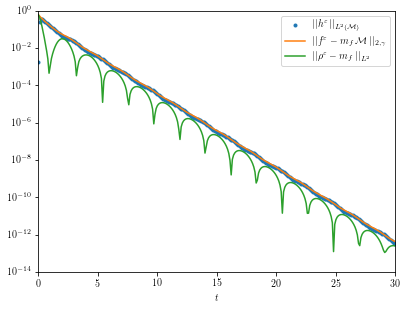

In [77]:
### Customization of the plot parameters ###
plt.rcParams['figure.figsize'] = 6.4, 4.8  # size of the inline plot, in inches
#plt.xkcd()
from matplotlib2tikz import save as tikz_save

#plt.semilogy(t,L2lamb_heat, label = r'$||\rho^{heat}-m_f\,||_{L^2}$')

### Return to equilibrium ###
rate = (np.log(L2f[40]) - np.log(L2f[10]))/(t[40] - t[10])

ax=plt.subplot(1,1,1)

plt.xlabel('$t$')
plt.semilogy(t,epsilon*L2h,'.', label = r'$||h^\varepsilon\,||_{L^2(\mathcal{M})}$')
plt.semilogy(t,L2f, label = r'$||f^\varepsilon-m_f\,\mathcal{M}\,||_{2,\gamma}$')
#plt.semilogy(t[10:40],1e-2*L2f[0]*np.exp(rate*np.array(t[10:40])), ':', label=r'$\alpha \exp({:0.2f}t)$'.format(rate))
#plt.legend()

#plt.subplot(1,2,2)

#plt.xlabel('$t$')
plt.semilogy(t,L2lamb, label = r'$||\rho^\varepsilon-m_f\,||_{L^2}$')
plt.ylim([1e-14,1])
plt.xlim([0,30])

#ax.yaxis.set_ticks_position('right')
#ax.yaxis.set_label_position('right')

plt.legend()
tikz_save("TrendToEq_Equation" + name + "_InitDat" + str(testcase) + "_Eps" + str(epsilon) + ".tex", figureheight='2.in', figurewidth='2.66in')

plt.show()

In [ ]:
rate

In [ ]:
### Snapshots of the distribution function ###
plt.rcParams['figure.figsize'] = 6., 1.3  # size of inline plots

plt.subplot(1,4,1)
plt.contourf(X,V,Fn[0], 50, cmap=plt.cm.viridis)
plt.xlabel(r'$x$')
plt.ylabel(r'$v$')

plt.tick_params(axis='both', which='major', labelsize=7)

ax=plt.subplot(1,4,2)
plt.contourf(X,V,Fn[3], 50, cmap=plt.cm.viridis)
ax.yaxis.set_ticks([])
plt.xlabel(r'$x$')
plt.tick_params(axis='both', which='major', labelsize=7)

ax=plt.subplot(1,4,3)
plt.contourf(X,V,Fn[6], 50, cmap=plt.cm.viridis)
plt.xlabel(r'$x$')
ax.yaxis.set_ticks([])
plt.tick_params(axis='both', which='major', labelsize=7)

ax=plt.subplot(1,4,4)
plt.contourf(X,V,Fn[-1], 50, cmap=plt.cm.viridis)
plt.xlabel(r'$x$')
plt.ylabel(r'$v$',)
ax.yaxis.set_ticks_position('right')
ax.yaxis.set_label_position('right')
plt.tick_params(axis='both', which='major', labelsize=7)

plt.savefig("PhaseSpace_Equation" + name + "_InitDat" + str(testcase) + "_Eps" + str(epsilon) + ".pdf", bbox_inches="tight")

plt.show()

In [ ]:
### Comparison between heat and kinetic ###
plt.rcParams['figure.figsize'] = 7, 6  # bigger inline plots

ax=plt.subplot(2,2,1)
plt.plot(x,rhon[0], 'k+', label=r'$\rho^\varepsilon$')
plt.plot(x,heatn[0], '-', label=r'$\rho_{heat}$')
plt.legend()
ax.xaxis.set_ticks([])

ax=plt.subplot(2,2,2)
plt.plot(x,rhon[1], 'k+', label=r'$\rho^\varepsilon$')
plt.plot(x,heatn[1], '-', label=r'$\rho_{heat}$')
plt.legend()
ax.xaxis.set_ticks([])

ax=plt.subplot(2,2,3)
plt.plot(x,rhon[2], 'k+', label=r'$\rho^\varepsilon$')
plt.plot(x,heatn[2], '-', label=r'$\rho_{heat}$')
plt.xlabel(r'$x$')
plt.legend()
#ax.yaxis.set_ticks([])

ax=plt.subplot(2,2,4)
plt.plot(x,rhon[-1], 'k+', label=r'$\rho^\varepsilon$')
plt.plot(x,heatn[-1], '-', label=r'$\rho_{heat}$')
plt.xlabel(r'$x$')
plt.legend()

tikz_save("KinVsHeat_Equation" + name + "_InitDat" + str(testcase) + "_Eps" + str(epsilon) + ".tex", figureheight='5.5cm', figurewidth='7cm')

In [166]:
Fneps_05 = Fn
L2f_05   = L2f

In [32]:
Fneps0 = Fn
L2f_0  = L2f

In [61]:
Fneps_01 = Fn
L2f_01   = L2f

In [80]:
Fneps_001 = Fn
L2f_001   = L2f

In [98]:
Fneps_0001 = Fn
L2f_0001   = L2f

In [116]:
Fneps_1em10 = Fn
L2f_1em10   = L2f

In [135]:
Fneps_inf = Fn
L2f_inf   = L2f

## Some more involved test cases ##

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Unsupported marker , (pixel).
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be i

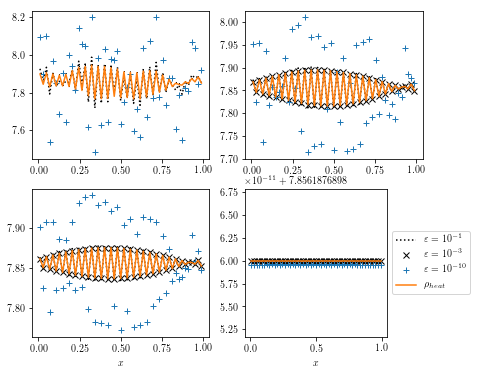

In [190]:
### Comparison between heat and kinetic ###
plt.rcParams['figure.figsize'] = 7, 6  # bigger inline plots

rho
ax=plt.subplot(2,2,1)
it = 1
#rho1 = np.transpose(np.sum(Fneps0[it] * DV,0))
#plt.plot(x,rho1, 'kx', label=r'$\varepsilon = 1$')
rho01 = np.transpose(np.sum(Fneps_01[it] * DV,0))
plt.plot(x,rho01, 'k:', label=r'$\varepsilon = 10^{-1}$')
rho0001 = np.transpose(np.sum(Fneps_0001[it] * DV,0))
plt.plot(x,rho0001, 'k,', label=r'$\varepsilon = 10^{-3}$')
plt.plot(x,rhon[it], '+', label=r'$\varepsilon = 10^{-10}$')
plt.plot(x,heatn[it], '-', label=r'Heat')

ax=plt.subplot(2,2,2)
it = 2
#rho1 = np.transpose(np.sum(Fneps0[it] * DV,0))
#plt.plot(x,rho1, 'kx', label=r'$\varepsilon = 1$')
rho01 = np.transpose(np.sum(Fneps_01[it] * DV,0))
plt.plot(x,rho01, 'k:', label=r'$\varepsilon = 10^{-1}$')
rho0001 = np.transpose(np.sum(Fneps_0001[it] * DV,0))
plt.plot(x,rho0001, 'kx', label=r'$\varepsilon = 10^{-3}$')
plt.plot(x,rhon[it], '+', label=r'$\varepsilon = 10^{-10}$')
plt.plot(x,heatn[it], '-', label=r'Heat')

ax=plt.subplot(2,2,3)
it = 3
#rho1 = np.transpose(np.sum(Fneps0[it] * DV,0))
#plt.plot(x,rho1, 'kx', label=r'$\varepsilon = 1$')
rho01 = np.transpose(np.sum(Fneps_01[it] * DV,0))
plt.plot(x,rho01, 'k:', label=r'$\varepsilon = 10^{-1}$')
rho0001 = np.transpose(np.sum(Fneps_0001[it] * DV,0))
plt.plot(x,rho0001, 'kx', label=r'$\varepsilon = 10^{-3}$')
plt.plot(x,rhon[it], '+', label=r'$\varepsilon = 10^{-10}$')
plt.plot(x,heatn[it], '-', label=r'Heat')
plt.xlabel(r'$x$')

ax=plt.subplot(2,2,4)
it = 50
#rho1 = np.transpose(np.sum(Fneps0[it] * DV,0))
#plt.plot(x,rho1, 'kx', label=r'$\varepsilon = 1$')
rho01 = np.transpose(np.sum(Fneps_01[it] * DV,0))
plt.plot(x,rho01, 'k:', label=r'$\varepsilon = 10^{-1}$')
rho0001 = np.transpose(np.sum(Fneps_0001[it] * DV,0))
plt.plot(x,rho0001, 'kx', label=r'$\varepsilon = 10^{-3}$')
plt.plot(x,rhon[it], '+', label=r'$\varepsilon = 10^{-10}$')
plt.plot(x,heatn[it], '-', label=r'$\rho_{heat}$')
plt.xlabel(r'$x$')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.legend()

tikz_save("KinVsHeat_Equation" + name + "_InitDat" + str(testcase) + "_MultiEps.tex", figureheight='5.5cm', figurewidth='7cm')

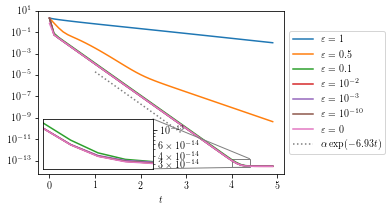

In [191]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
plt.rcParams['figure.figsize'] = 5.5, 3  # size of inline plots

### Influence of epsilon on the rate of decay ###
rMax, rmin = 30,10

rate = (np.log(L2f_inf[rMax]) - np.log(L2f_inf[rmin]))/(t[rMax] - t[rmin])

ax=plt.subplot(1,1,1)

plt.xlabel('$t$')
plt.semilogy(t[0:50],L2f_0[0:50], label = r'$\varepsilon=1$')
plt.semilogy(t[0:50],L2f_05[0:50], label = r'$\varepsilon=0.5$')
plt.semilogy(t[0:50],L2f_01[0:50], label = r'$\varepsilon=0.1$')
plt.semilogy(t[0:50],L2f_001[0:50], label = r'$\varepsilon=10^{-2}$')
plt.semilogy(t[0:50],L2f_0001[0:50], label = r'$\varepsilon=10^{-3}$')
plt.semilogy(t[0:50],L2f_1em10[0:50], label = r'$\varepsilon=10^{-10}$')
plt.semilogy(t[0:50],L2f_inf[0:50], label = r'$\varepsilon=0$')

plt.semilogy(t[10:30],1e-2*L2f_1em10[0]*np.exp(rate*np.array(t[10:30])), ':', label=r'$\alpha \exp({:0.2f}t)$'.format(rate))

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#plt.legend()

### On zoome d'un facteur fact pour mieux voir ###
fact = 6
axins = zoomed_inset_axes(ax, fact, loc=3)

axins.semilogy(t[0:50],L2f_0[0:50], label = r'$\varepsilon=1$')
axins.semilogy(t[0:50],L2f_05[0:50], label = r'$\varepsilon=0.5$')
axins.semilogy(t[0:50],L2f_01[0:50], label = r'$\varepsilon=10^{-1}$')
axins.semilogy(t[0:50],L2f_001[0:50], label = r'$\varepsilon=10^{-2}$')
axins.semilogy(t[0:50],L2f_0001[0:50], label = r'$\varepsilon=10^{-3}$')
axins.semilogy(t[0:50],L2f_1em10[0:50], label = r'$\varepsilon=10^{-10}$')
axins.semilogy(t[0:50],L2f_inf[0:50], label = r'$\varepsilon=0$')

# sub region of the original image
x1, x2, y1, y2 = 4., 4.4, 2.5e-14, 1.5e-13

axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.yaxis.set_ticks_position('right')
plt.xticks([])  # Not present ticks

# draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
mark_inset(ax, axins, loc1=4, loc2=1, fc="none", ec="0.5")
    
plt.savefig("CompRateEps_Equation" + name + "_InitDat" + str(testcase) + ".pdf", bbox_inches="tight")

plt.show()

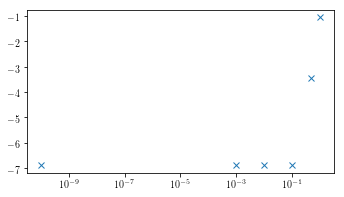

In [189]:
eps_valStr = ['_0','_05','_01','_001','_0001','_1em10', '_inf']
eps_val    = np.array([1,0.5,0.1,0.01,0.001,1e-10,0])
rate_val   = []
it         = 0
rMax, rmin = 40,22

for epsStr in eps_valStr:
    L2f_eps = eval(str('L2f'+epsStr)) 
    rate_val.append((np.log(L2f_eps[rMax]) - np.log(L2f_eps[rmin]))/(t[rMax] - t[rmin]))

plt.semilogx(eps_values,rate_val,'x')
#eps_val, rate_val

In [ ]:
### MOVIE ###
plt.rcParams['figure.figsize'] = 12.8, 9.6   # size of inline plots
picsName = "PhaseSpace_Equation" + name + "_InitDat" + str(testcase) + "_Eps" + str(epsilon) + "_N"

for i in range(100):
    plt.contourf(X,V,Fn[i], 50, cmap=plt.cm.viridis)
    plt.xlabel(r'$x$')
    plt.ylabel(r'$v$')

    #plt.tick_params(axis='both', which='major', labelsize=7)
    plt.savefig(picsName + str(i) + ".png", bbox_inches="tight")


In [ ]:
import os
os.system('ffmpeg -framerate 10 -i picsName%02d.png -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p -vf scale=1280:-2 output.mp4')

In [171]:
eval(str('L2f'+'_0')) 

array([2.04005122, 1.7055936 , 1.48031459, 1.30204565, 1.15374449,
       1.02707555, 0.91726609, 0.8211848 , 0.73656493, 0.66166702,
       0.59510893, 0.53576709, 0.48271328, 0.43517145, 0.39248665,
       0.35410175, 0.31953929, 0.28838714, 0.26028706, 0.23492551,
       0.21202636, 0.19134505, 0.17266389, 0.15578831, 0.14054384,
       0.12677359, 0.11433619, 0.10310403, 0.09296182, 0.08380527,
       0.07554   , 0.0680806 , 0.06134969, 0.05527722, 0.04979974,
       0.04485982, 0.04040545, 0.03638955, 0.03276953, 0.02950685,
       0.02656666, 0.02391745, 0.02153072, 0.01938073, 0.01744421,
       0.01570018, 0.01412964, 0.01271548, 0.01144225, 0.010296  ,
       0.00926414, 0.00833532])